In [ ]:
from scipy.interpolate import RegularGridInterpolator
import numpy as np
import matplotlib.pyplot as plt
import segyio


In [ ]:
# https://github.com/PyLops/pylops_4ways/blob/main/notebooks/Poststack_GPU.ipynb
# https://docs.cupy.dev/en/stable/user_guide/basic.html

In [8]:
segyfile = 'ST10010ZC11_PZ_PSDM_KIRCH_FAR_D.MIG_FIN.POST_STACK.3D.JS-017536.segy'
f = segyio.open(segyfile, ignore_geometry=True)


# Data
itmin = 600 # index of first time/depth sample in data used in colored inversion
itmax = 800 # index of last time/depth sample in data used in colored inversion
# Subsampling (can save file at the end only without subsampling)
jt = 1
jil = 1
jxl = 1

traces = segyio.collect(f.trace)[:]
traces = traces[:, itmin:itmax]
ntraces, nt = traces.shape

t = f.samples[itmin:itmax]
il = f.attributes(segyio.TraceField.INLINE_3D)[:]
xl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]

# Define regular IL and XL axes
il_unique = np.unique(il)
xl_unique = np.unique(xl)

il_min, il_max = min(il_unique), max(il_unique)
xl_min, xl_max = min(xl_unique), max(xl_unique)

dt = t[1] - t[0]
dil = min(np.unique(np.diff(il_unique)))
dxl = min(np.unique(np.diff(xl_unique)))

ilines = np.arange(il_min, il_max + dil, dil)
xlines = np.arange(xl_min, xl_max + dxl, dxl)
nil, nxl = ilines.size, xlines.size

ilgrid, xlgrid = np.meshgrid(np.arange(nil),
                             np.arange(nxl),
                             indexing='ij')

# Look-up table
traces_indeces = np.full((nil, nxl), np.nan)
iils = (il - il_min) // dil
ixls = (xl - xl_min) // dxl
traces_indeces[iils, ixls] = np.arange(ntraces)
traces_available = np.logical_not(np.isnan(traces_indeces))

# Reorganize traces in regular grid
d = np.zeros((nil, nxl, nt))
d[ilgrid.ravel()[traces_available.ravel()],
  xlgrid.ravel()[traces_available.ravel()]] = traces

# Subsample
d = d[::jil, ::jxl, ::jt]
ilines = ilines[::jil]
xlines = xlines[::jxl]
t = t[::jt]
nil, nxl, nt = len(ilines), len(xlines), len(t)

In [10]:
segyfilev = 'ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'
fv = segyio.open(segyfilev)
v = segyio.cube(fv)

IL, XL, T = np.meshgrid(ilines, xlines, t, indexing='ij')

vinterp = RegularGridInterpolator((fv.ilines, fv.xlines, fv.samples), v, 
                                  bounds_error=False, fill_value=0)
vinterp = vinterp(np.vstack((IL.ravel(), XL.ravel(), T.ravel())).T)
vinterp = vinterp.reshape(nil, nxl, nt)

In [19]:
fv.ilines,IL.max(),IL.min(),IL.shape,fv.ilines.size,IL[0,0,0],IL[1,1,1]

(array([ 9963,  9967,  9971,  9975,  9979,  9983,  9987,  9991,  9995,
         9999, 10003, 10007, 10011, 10015, 10019, 10023, 10027, 10031,
        10035, 10039, 10043, 10047, 10051, 10055, 10059, 10063, 10067,
        10071, 10075, 10079, 10083, 10087, 10091, 10095, 10099, 10103,
        10107, 10111, 10115, 10119, 10123, 10127, 10131, 10135, 10139,
        10143, 10147, 10151, 10155, 10159, 10163, 10167, 10171, 10175,
        10179, 10183, 10187, 10191, 10195, 10199, 10203, 10207, 10211,
        10215, 10219, 10223, 10227, 10231, 10235, 10239, 10243, 10247,
        10251, 10255, 10259, 10263, 10267, 10271, 10275, 10279, 10283,
        10287, 10291, 10295, 10299, 10303, 10307, 10311, 10315, 10319,
        10323, 10327, 10331, 10335, 10339, 10343, 10347, 10351, 10355,
        10359, 10363, 10367, 10371, 10375, 10379, 10383, 10387, 10391,
        10395], dtype=int32),
 np.int64(10361),
 np.int64(9961),
 (401, 720, 200),
 109,
 np.int64(9961),
 np.int64(9962))

In [12]:
v.shape,vinterp.shape

((109, 241, 226), (401, 720, 200))

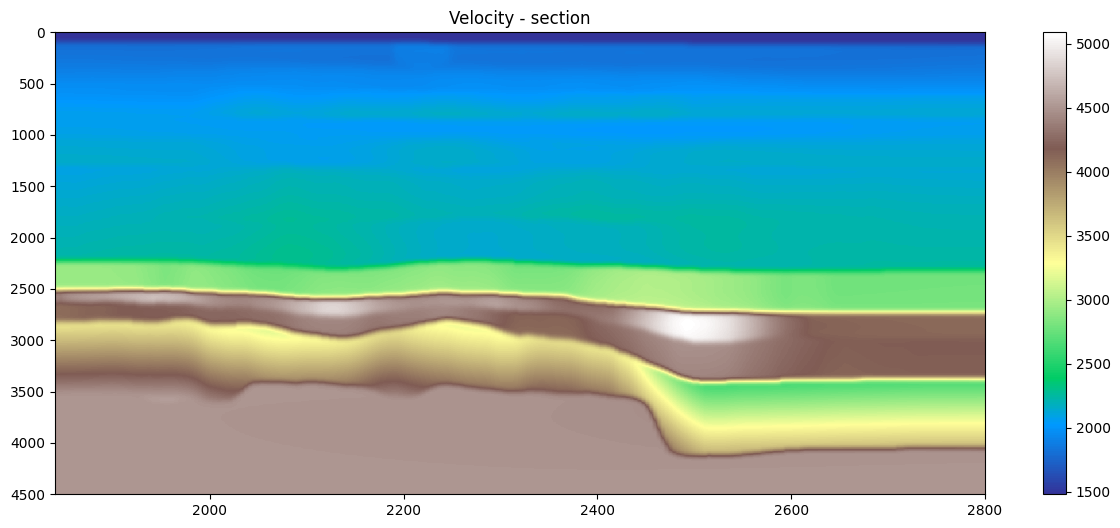

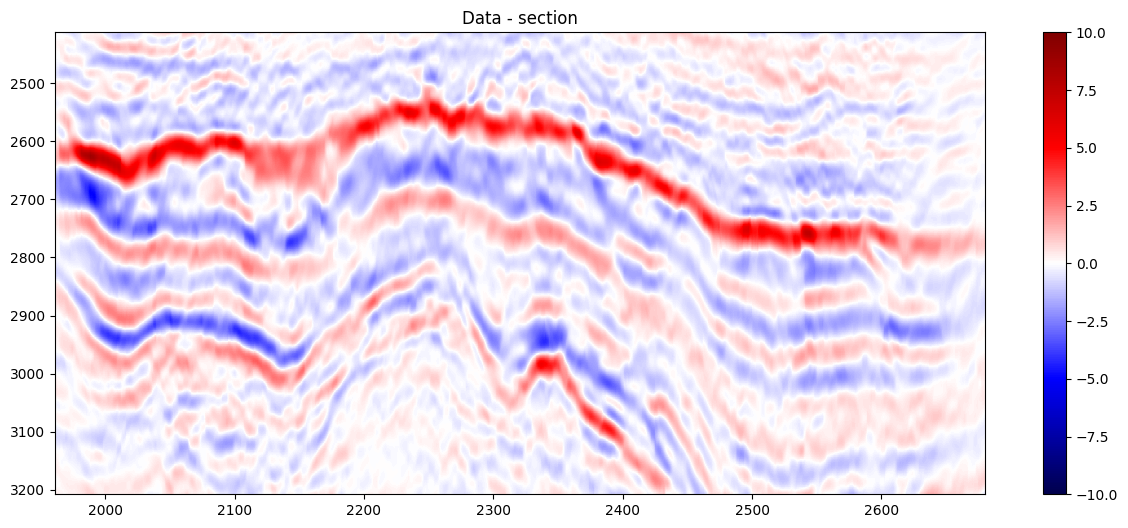

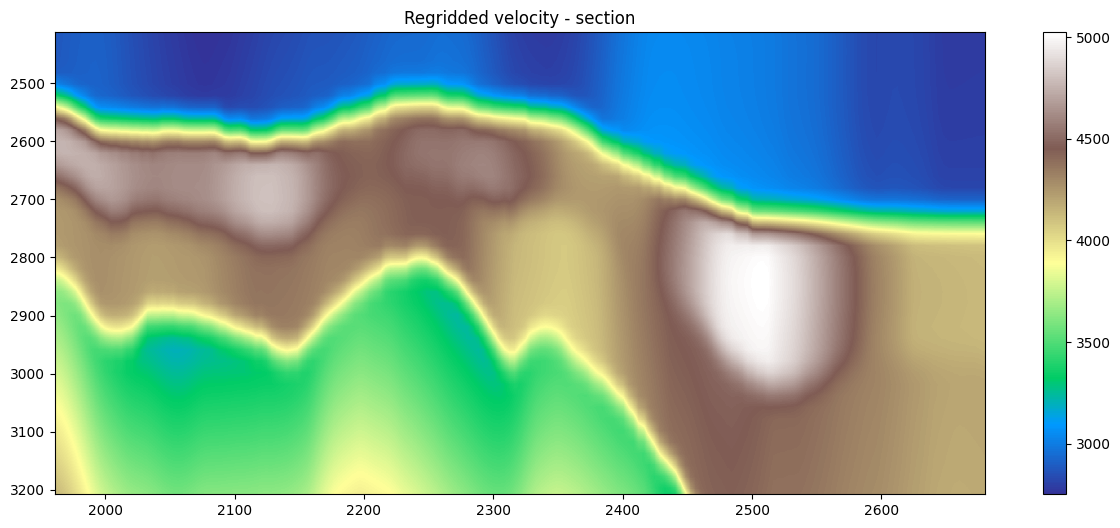

In [13]:
# Display data
plt.figure(figsize=(15, 6))
plt.imshow(v[len(fv.ilines)//2].T, cmap='terrain',
           extent=(fv.xlines[0], fv.xlines[-1], fv.samples[-1], fv.samples[0]))
plt.title('Velocity - section')
plt.colorbar()
plt.axis('tight')

# Display data
plt.figure(figsize=(15, 6))
plt.imshow(d[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
           extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title('Data - section')
plt.colorbar()
plt.axis('tight');

# Display data
plt.figure(figsize=(15, 6))
plt.imshow(vinterp[nil//2].T, cmap='terrain',
           extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title('Regridded velocity - section')
plt.colorbar()
plt.axis('tight');

In [ ]:
import numpy as np
import cupy as cp
import segyio
from scipy.interpolate import RegularGridInterpolator

# Load SEGY file
segyfilev = 'ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'
fv = segyio.open(segyfilev)
v = segyio.cube(fv)

# Define grids
ilines = fv.ilines
xlines = fv.xlines
t = fv.samples

# Move data to GPU
v_gpu = cp.asarray(v)
ilines_gpu = cp.asarray(ilines)
xlines_gpu = cp.asarray(xlines)
t_gpu = cp.asarray(t)

# Create meshgrid
IL_gpu, XL_gpu, T_gpu = cp.meshgrid(ilines_gpu, xlines_gpu, t_gpu, indexing='ij')

# Define interpolation (fallback to NumPy/SciPy RegularGridInterpolator for simplicity)
vinterp_func = RegularGridInterpolator(
    (ilines, xlines, t),
    v,
    bounds_error=False,
    fill_value=0
)

# Use the interpolation function
interp_points = cp.vstack((IL_gpu.ravel(), XL_gpu.ravel(), T_gpu.ravel())).T
interp_points_host = cp.asnumpy(interp_points)  # Transfer to CPU for interpolation
vinterp_host = vinterp_func(interp_points_host)
vinterp_gpu = cp.asarray(vinterp_host)  # Transfer back to GPU

# Reshape to desired dimensions
nil, nxl, nt = len(ilines), len(xlines), len(t)
vinterp_gpu = vinterp_gpu.reshape(nil, nxl, nt)

# Print result (on CPU for verification)
vinterp_result = cp.asnumpy(vinterp_gpu)  # Transfer back to CPU for viewing
print("Interpolated volume shape:", vinterp_result.shape)
